In [1]:
from scipy.cluster.hierarchy import fcluster
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import re
import string
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from pylab import *
import nltk
import warnings
warnings.filterwarnings('ignore')
from scipy.cluster.hierarchy import ward, dendrogram
import seaborn as sns; 
sns.set()
import numpy as np
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve,cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
import datetime
from sklearn.metrics import accuracy_score,roc_curve,classification_report,confusion_matrix,precision_recall_curve,auc

In [2]:
# Load the data. 
reviewdata=pd.read_csv('data/clean_up_data.csv')

In [3]:
reviewdata.head()

,star_rating,helpful_votes,total_votes,helpful_votes_ratio,review_length,arrange_product_id,arrange_product_title,arrange_product_parent,arrange_customer_id,product_title,review_body
0,5,0,0,0.000000,14,783255.0,696893.0,696055.0,1015876.0,"Scotch Cushion Wrap 7961, 12 Inches x 100 Feet",Great product.
1,5,0,1,0.000000,155,1964694.0,1881711.0,1885670.0,1801693.0,"Dust-Off Compressed Gas Duster, Pack of 4",What's to say about this commodity item except...
2,5,0,0,0.000000,47,554316.0,499073.0,500576.0,548574.0,Amram Tagger Standard Tag Attaching Tagging Gu...,"Haven't used yet, but I am sure I will like it."
3,1,2,3,0.666667,735,2150992.0,2099828.0,2103291.0,719312.0,AmazonBasics 12-Sheet High-Security Micro-Cut ...,Although this was labeled as &#34;new&#34; the...
4,4,0,0,0.000000,31,1460506.0,1848076.0,1845831.0,103335.0,"Derwent Colored Pencils, Inktense Ink Pencils,...",Gorgeous colors and easy to use


In [4]:
reviewdata['classified_review']=0

In [5]:
reviewdata.loc[reviewdata['helpful_votes_ratio']>0.5,'classified_review']=1

In [6]:
reviewdata.head()

,star_rating,helpful_votes,total_votes,helpful_votes_ratio,review_length,arrange_product_id,arrange_product_title,arrange_product_parent,arrange_customer_id,product_title,review_body,classified_review
0,5,0,0,0.000000,14,783255.0,696893.0,696055.0,1015876.0,"Scotch Cushion Wrap 7961, 12 Inches x 100 Feet",Great product.,0
1,5,0,1,0.000000,155,1964694.0,1881711.0,1885670.0,1801693.0,"Dust-Off Compressed Gas Duster, Pack of 4",What's to say about this commodity item except...,0
2,5,0,0,0.000000,47,554316.0,499073.0,500576.0,548574.0,Amram Tagger Standard Tag Attaching Tagging Gu...,"Haven't used yet, but I am sure I will like it.",0
3,1,2,3,0.666667,735,2150992.0,2099828.0,2103291.0,719312.0,AmazonBasics 12-Sheet High-Security Micro-Cut ...,Although this was labeled as &#34;new&#34; the...,1
4,4,0,0,0.000000,31,1460506.0,1848076.0,1845831.0,103335.0,"Derwent Colored Pencils, Inktense Ink Pencils,...",Gorgeous colors and easy to use,0


In [7]:
lemmatizer = WordNetLemmatizer()
stop_words = stopwords.words('english')
stop_words = stop_words + list(string.printable)

In [8]:
reviewdata['cleaned_review'] = reviewdata['review_body'].apply(\
lambda x : ' '.join([lemmatizer.lemmatize(word.lower()) \
    for word in word_tokenize(re.sub(r'([^\s\w]|_)+', ' ', str(x))) if word.lower() not in stop_words]))

In [9]:
def clf_model(model_type, X_train, y_train, X_test):
    model = model_type.fit(X_train,y_train)
    predicted_labels = model.predict(X_test)
    predicted_probab = model.predict_proba(X_test)[:,1]
    return [predicted_labels,predicted_probab, model]

In [10]:
def model_evaluation(actual_values, predicted_values, predicted_probabilities):
    cfn_mat = confusion_matrix(actual_values,predicted_values,labels=[0, 1])
    print("confusion matrix: \n",cfn_mat)
    print("\naccuracy: ",accuracy_score(actual_values,predicted_values))
    print("\nclassification report: \n", classification_report(actual_values,predicted_values))
    # Compute ROC curve and ROC area for each class
#     fpr = dict()
#     tpr = dict()
#     roc_auc = dict()
#     for i in range(3):
#         fpr[i], tpr[i], _ = roc_curve(actual_values[:, i], predicted_values[:, i])
#         roc_auc[i] = auc(fpr[i], tpr[i])

# # Compute micro-average ROC curve and ROC area
#     fpr["micro"], tpr["micro"], _ = roc_curve(actual_values.ravel(), predicted_values.ravel())
#     roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    fpr,tpr,threshold=roc_curve(actual_values, predicted_probabilities)
    print ('\nArea under ROC curve for validation set:', auc(fpr,tpr))
    fig, ax = plt.subplots(figsize=(6,6))
    ax.plot(fpr,tpr,label='Validation set AUC')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    ax.legend(loc='best')
    plt.show()

In [11]:
tfidf_model = TfidfVectorizer(max_features=50)
tfidf_df = pd.DataFrame(tfidf_model.fit_transform(reviewdata['cleaned_review']).todense())
tfidf_df.columns = sorted(tfidf_model.vocabulary_)
tfidf_df.head()

,34,also,back,bought,br,buy,cartridge,color,easy,even,...,set,thing,time,use,used,using,well,work,would,year
0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0
1,0.00000,0.0,0.0,0.0,0.516693,0.0,0.0,0.00000,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0
2,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.760549,0.0,0.0,0.000000,0.0,0.0
3,0.66983,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.138623,0.0,0.0,0.194986,0.0,0.0
4,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.63401,0.597541,0.0,...,0.0,0.0,0.0,0.490893,0.000000,0.0,0.0,0.000000,0.0,0.0


In [12]:
df2=reviewdata.drop(columns=['helpful_votes_ratio','classified_review','review_body','product_title','total_votes','helpful_votes','cleaned_review'])

In [13]:
df2=pd.concat([tfidf_df, df2], axis=1)

In [14]:
df2.head()

,34,also,back,bought,br,buy,cartridge,color,easy,even,...,well,work,would,year,star_rating,review_length,arrange_product_id,arrange_product_title,arrange_product_parent,arrange_customer_id
0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.000000,0.0,...,0.0,0.000000,0.0,0.0,5,14,783255.0,696893.0,696055.0,1015876.0
1,0.00000,0.0,0.0,0.0,0.516693,0.0,0.0,0.00000,0.000000,0.0,...,0.0,0.000000,0.0,0.0,5,155,1964694.0,1881711.0,1885670.0,1801693.0
2,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.000000,0.0,...,0.0,0.000000,0.0,0.0,5,47,554316.0,499073.0,500576.0,548574.0
3,0.66983,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.000000,0.0,...,0.0,0.194986,0.0,0.0,1,735,2150992.0,2099828.0,2103291.0,719312.0
4,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.63401,0.597541,0.0,...,0.0,0.000000,0.0,0.0,4,31,1460506.0,1848076.0,1845831.0,103335.0


In [15]:
X_train, X_test, y_train, y_test = train_test_split(df2, 
                                                    reviewdata.classified_review, test_size=0.3, 
                                                    random_state=47)

In [16]:
y_train.value_counts()

0    1182572
1     396515
Name: classified_review, dtype: int64

In [17]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train))
X_train.columns=df2.columns
X_test = pd.DataFrame(scaler.transform(X_test))
X_test.columns=df2.columns
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

In [18]:
from sklearn.utils import resample
train_data = pd.concat([X_train, y_train], axis=1)
negative = train_data[train_data['classified_review']==0]
positive = train_data[train_data['classified_review']==1]
neg_downsampled = resample(negative,replace=True,n_samples=len(positive),random_state=21)
downsampled = pd.concat([positive, neg_downsampled])


In [19]:
y_train=downsampled.classified_review
X_train=downsampled.drop(columns='classified_review')

confusion matrix: 
 [[360651 146606]
 [ 66791 102704]]

accuracy:  0.6846747405253327

classification report: 
               precision    recall  f1-score   support

           0       0.84      0.71      0.77    507257
           1       0.41      0.61      0.49    169495

    accuracy                           0.68    676752
   macro avg       0.63      0.66      0.63    676752
weighted avg       0.74      0.68      0.70    676752


Area under ROC curve for validation set: 0.7247705779175934


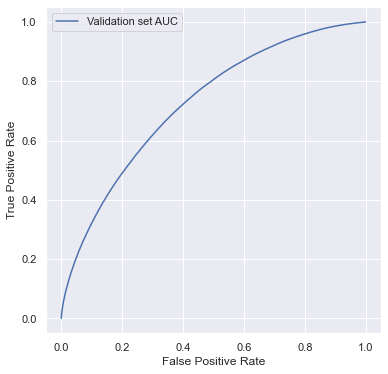

In [20]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
results = clf_model(logreg, X_train, y_train, X_test)
logreg_accuracy=accuracy_score(y_test,results[0])
model_evaluation(y_test, results[0], results[1])
model_logreg=results[2]

In [21]:
from sklearn.model_selection import cross_val_score

cv_scores_test= cross_val_score(logreg,X_test,y_test,cv=5,scoring='roc_auc')
cv_scores_train= cross_val_score(logreg,X_train,y_train,cv=5,scoring='roc_auc')
print(cv_scores_test)
cv_scores_lr_test= cv_scores_test.mean()
cv_scores_lr_train= cv_scores_train.mean()
cv_scores_std_test_lr= cv_scores_test.std()
print ('Mean cross validation test score: ' +str(cv_scores_lr_test))
print ('Mean cross validation train score: ' +str(cv_scores_lr_train))
print ('Standard deviation in cv test scores: ' +str(cv_scores_std_test_lr))

[0.72038407 0.72187378 0.72327876 0.72186058 0.72163767]
Mean cross validation test score: 0.7218069724868458
Mean cross validation train score: 0.7264299718504004
Standard deviation in cv test scores: 0.0009194344516136567


confusion matrix: 
 [[332057 175200]
 [ 55464 114031]]

accuracy:  0.6591602241293709

classification report: 
               precision    recall  f1-score   support

           0       0.86      0.65      0.74    507257
           1       0.39      0.67      0.50    169495

    accuracy                           0.66    676752
   macro avg       0.63      0.66      0.62    676752
weighted avg       0.74      0.66      0.68    676752


Area under ROC curve for validation set: 0.7244860698273822


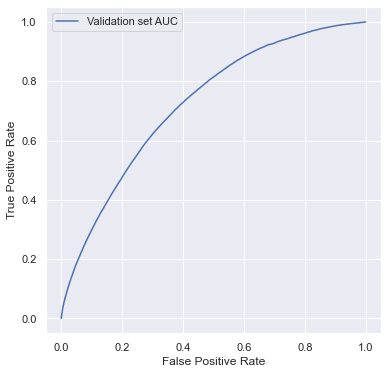

In [22]:
from sklearn.ensemble import RandomForestClassifier 
rfc = RandomForestClassifier(n_estimators=20,max_depth=4,max_features='sqrt',random_state=1)
results = clf_model(rfc, X_train, y_train, X_test)
rfc_accuracy=accuracy_score(y_test,results[0])
model_evaluation(y_test, results[0], results[1])
model_rfc=results[2]

In [23]:
from sklearn.model_selection import cross_val_score

cv_scores_test= cross_val_score(rfc,X_test,y_test,cv=5,scoring='roc_auc')
cv_scores_train= cross_val_score(rfc,X_train,y_train,cv=5,scoring='roc_auc')
print(cv_scores_test)
cv_scores_rfc_test= cv_scores_test.mean()
cv_scores_rfc_train= cv_scores_train.mean()
cv_scores_std_test_rfc= cv_scores_test.std()
print ('Mean cross validation test score: ' +str(cv_scores_rfc_test))
print ('Mean cross validation train score: ' +str(cv_scores_rfc_train))
print ('Standard deviation in cv test scores: ' +str(cv_scores_std_test_rfc))

[0.72485879 0.72545951 0.72424667 0.72335373 0.72396363]
Mean cross validation test score: 0.7243764669189676
Mean cross validation train score: 0.7268313853858956
Standard deviation in cv test scores: 0.0007264827639875706


In [24]:
word_importances = pd.DataFrame({'word':df2.columns,'importance':model_rfc.feature_importances_})
word_importances.sort_values('importance', ascending = False).head(20)

,word,importance
51,review_length,0.381755
26,one,0.098257
9,even,0.054728
43,use,0.047962
17,like,0.046129
11,get,0.043362
53,arrange_product_title,0.039600
48,would,0.039192
1,also,0.034393
52,arrange_product_id,0.030150


[21:20:18] WARNING: D:\bld\xgboost-split_1634712635879\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
confusion matrix: 
 [[333910 173347]
 [ 52762 116733]]

accuracy:  0.6658909024280681

classification report: 
               precision    recall  f1-score   support

           0       0.86      0.66      0.75    507257
           1       0.40      0.69      0.51    169495

    accuracy                           0.67    676752
   macro avg       0.63      0.67      0.63    676752
weighted avg       0.75      0.67      0.69    676752


Area under ROC curve for validation set: 0.7396020195973956


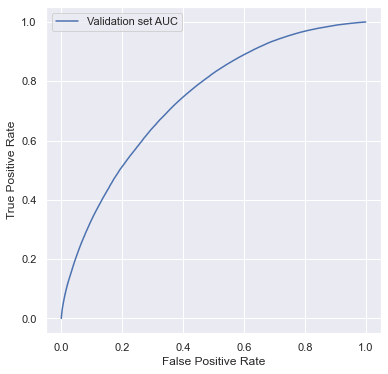

In [25]:
from xgboost import XGBClassifier
xgb_clf=XGBClassifier(n_estimators=20,learning_rate=0.03,max_depth=5,subsample=0.6,colsample_bytree= 0.6,reg_alpha= 10,seed=42)
results = clf_model(xgb_clf, X_train, y_train, X_test)
xgb_accuracy=accuracy_score(y_test,results[0])
model_evaluation(y_test, results[0], results[1])
model_xgb=results[2]

In [26]:
cv_scores_test= cross_val_score(xgb_clf,X_test,y_test,cv=5,scoring='roc_auc')
cv_scores_train= cross_val_score(xgb_clf,X_train,y_train,cv=5,scoring='roc_auc')
print(cv_scores_test)
cv_scores_xgb_test= cv_scores_test.mean()
cv_scores_xgb_train= cv_scores_train.mean()
cv_scores_std_test_xgb= cv_scores_test.std()
print ('Mean cross validation test score: ' +str(cv_scores_xgb_test))
print ('Mean cross validation train score: ' +str(cv_scores_xgb_train))
print ('Standard deviation in cv test scores: ' +str(cv_scores_std_test_xgb))

[21:20:27] WARNING: D:\bld\xgboost-split_1634712635879\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:20:32] WARNING: D:\bld\xgboost-split_1634712635879\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:20:36] WARNING: D:\bld\xgboost-split_1634712635879\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:20:41] WARNING: D:\bld\xgboost-split_1634712635879\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation me

In [27]:
word_importances = pd.DataFrame({'word':df2.columns,'importance':model_xgb.feature_importances_})
word_importances.sort_values('importance', ascending = False).head(20)

,word,importance
4,br,0.221614
51,review_length,0.218692
26,one,0.095787
14,great,0.047620
31,phone,0.040927
40,set,0.039575
43,use,0.038228
53,arrange_product_title,0.034232
33,print,0.032826
17,like,0.028759


confusion matrix: 
 [[329219 178038]
 [ 69820  99675]]

accuracy:  0.6337535759037284

classification report: 
               precision    recall  f1-score   support

           0       0.83      0.65      0.73    507257
           1       0.36      0.59      0.45    169495

    accuracy                           0.63    676752
   macro avg       0.59      0.62      0.59    676752
weighted avg       0.71      0.63      0.66    676752


Area under ROC curve for validation set: 0.6639027596370204


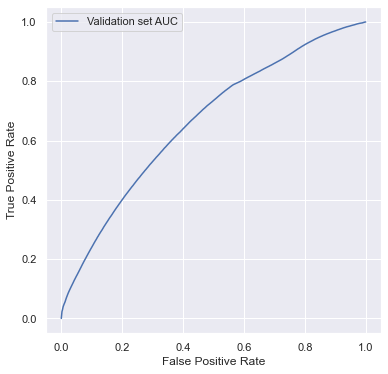

In [28]:
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
results = clf_model(nb, X_train, y_train, X_test)
nb_accuracy=accuracy_score(y_test,results[0])
model_evaluation(y_test, results[0], results[1])
model_nb=results[2]

In [29]:
cv_scores_test= cross_val_score(nb,X_test,y_test,cv=5,scoring='roc_auc')
cv_scores_train= cross_val_score(nb,X_train,y_train,cv=5,scoring='roc_auc')
print(cv_scores_test)
cv_scores_nb_test= cv_scores_test.mean()
cv_scores_nb_train= cv_scores_train.mean()
cv_scores_std_test_nb= cv_scores_test.std()
print ('Mean cross validation test score: ' +str(cv_scores_nb_test))
print ('Mean cross validation train score: ' +str(cv_scores_nb_train))
print ('Standard deviation in cv test scores: ' +str(cv_scores_std_test_nb))

[0.66329955 0.66241527 0.66521584 0.66419945 0.66282541]
Mean cross validation test score: 0.663591105594663
Mean cross validation train score: 0.6656226335352939
Standard deviation in cv test scores: 0.001006353781577203


confusion matrix: 
 [[338248 169009]
 [ 62322 107173]]

accuracy:  0.6581746341348086

classification report: 
               precision    recall  f1-score   support

           0       0.84      0.67      0.75    507257
           1       0.39      0.63      0.48    169495

    accuracy                           0.66    676752
   macro avg       0.62      0.65      0.61    676752
weighted avg       0.73      0.66      0.68    676752


Area under ROC curve for validation set: 0.7084693525043793


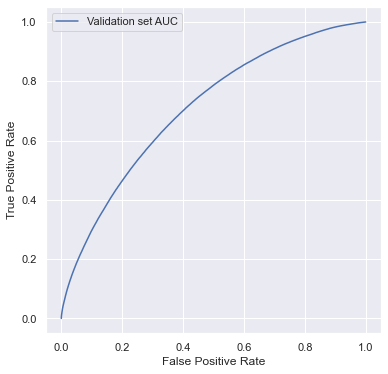

In [30]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
LDA = LinearDiscriminantAnalysis()
results = clf_model(LDA, X_train, y_train, X_test)
LDA_accuracy=accuracy_score(y_test,results[0])
model_evaluation(y_test, results[0], results[1])
model_LDA=results[2]

In [31]:
cv_scores_test= cross_val_score(LDA,X_test,y_test,cv=5,scoring='roc_auc')
cv_scores_train= cross_val_score(LDA,X_train,y_train,cv=5,scoring='roc_auc')
print(cv_scores_test)
cv_scores_LDA_test= cv_scores_test.mean()
cv_scores_LDA_train= cv_scores_train.mean()
cv_scores_std_test_LDA= cv_scores_test.std()
print ('Mean cross validation test score: ' +str(cv_scores_LDA_test))
print ('Mean cross validation train score: ' +str(cv_scores_LDA_train))
print ('Standard deviation in cv test scores: ' +str(cv_scores_std_test_LDA))

[0.71606999 0.71718032 0.7195546  0.71761434 0.71736058]
Mean cross validation test score: 0.7175559658615499
Mean cross validation train score: 0.7103228885116681
Standard deviation in cv test scores: 0.0011300769414217889


In [32]:
modelLabels = [ 'Logistic Regression','Random Forest','Gradient Boost', 'Naive Bayes','Linear Discriminant Analysis']
score_test= [cv_scores_lr_test,cv_scores_rfc_test,cv_scores_xgb_test,cv_scores_nb_test,cv_scores_LDA_test]
score_train= [cv_scores_lr_train,cv_scores_rfc_train,cv_scores_xgb_train,cv_scores_nb_train,cv_scores_LDA_train]
score_tab = pd.DataFrame(list(zip(modelLabels, score_train, score_test)), 
               columns =['Algorithm', 'ROC-AUC train score', 'ROC-AUC test score' ]) 

score_tab

,Algorithm,ROC-AUC train score,ROC-AUC test score
0,Logistic Regression,0.726430,0.721807
1,Random Forest,0.726831,0.724376
2,Gradient Boost,0.740649,0.739027
3,Naive Bayes,0.665623,0.663591
4,Linear Discriminant Analysis,0.710323,0.717556


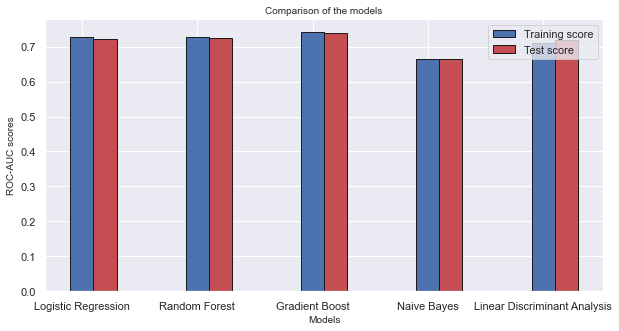

In [33]:
index1=[1,2,3,4,5]
index2=[1.2,2.2,3.2,4.2,5.2]
plt.figure(figsize=(10,5))
plt.xlabel('Models',fontsize=10)
plt.ylabel ('ROC-AUC scores',fontsize=10)
plt.title('Comparison of the models',fontsize=10)
_=plt.bar(index1,score_train,color='b',label='Training score',edgecolor='k',width=0.2)
_=plt.bar(index2,score_test,color='r',label='Test score',edgecolor='k',width=0.2)
plt.xticks([1,2,3,4,5], modelLabels)
plt.legend()
plt.savefig("ModelCompare.png")
plt.show()

In [43]:
GB = XGBClassifier()
gb_param = {
        'n_estimators' : [20,40,60],
        'learning_rate': [0.1, 0.03],
        'max_depth': [5,10],
        'subsample': [0.6],
        'colsample_bytree': [0.6] ,
        'reg_alpha':[0,1]
        }

gsGB = GridSearchCV(GB, param_grid = gb_param, cv=2, scoring="roc_auc", n_jobs= -1, verbose = 1)
gsGB.fit(X_train,y_train)
print(gsGB.best_estimator_)
print(gsGB.best_score_)

Fitting 2 folds for each of 24 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:  5.1min finished


[21:46:48] WARNING: D:\bld\xgboost-split_1634712635879\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6,
              enable_categorical=False, gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=60, n_jobs=16, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=1, reg_lambda=1, scale_pos_weight=1,
              subsample=0.6, tree_method='exact', validate_parameters=1,
              verbosity=None)
0.7524534191135238


[21:50:26] WARNING: D:\bld\xgboost-split_1634712635879\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
confusion matrix: 
 [[330057 177200]
 [ 48777 120718]]

accuracy:  0.6660859517223444

classification report: 
               precision    recall  f1-score   support

           0       0.87      0.65      0.74    507257
           1       0.41      0.71      0.52    169495

    accuracy                           0.67    676752
   macro avg       0.64      0.68      0.63    676752
weighted avg       0.75      0.67      0.69    676752


Area under ROC curve for validation set: 0.7505762600357024


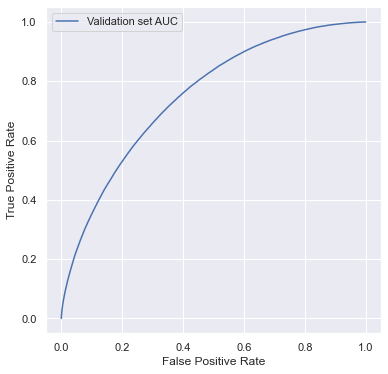

In [44]:
xgb_clf=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6,
              enable_categorical=False, gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=60, n_jobs=16, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=1, reg_lambda=1, scale_pos_weight=1,
              subsample=0.6, tree_method='exact', validate_parameters=1,
              verbosity=None)
results = clf_model(xgb_clf, X_train, y_train, X_test)
xgb_accuracy=accuracy_score(y_test,results[0])
model_evaluation(y_test, results[0], results[1])
model_xgb=results[2]

In [39]:
from xgboost import __version__ as xgboost_version

In [40]:
best_model = gsGB.best_estimator_
best_model.version = '1.0'
best_model.pandas_version = pd.__version__
best_model.numpy_version = np.__version__
best_model.xgboost_version = xgboost_version
best_model.X_columns = [col for col in X_train.columns]
best_model.build_datetime = datetime.datetime.now()

In [42]:
from library.sb_utils import save_file
modelpath = '../models'
save_file(best_model, 'Amazon_Office_Product_Helpful_Review_Classification.pkl', modelpath)

Directory ../models was created.
Writing file.  "../models\Amazon_Office_Product_Helpful_Review_Classification.pkl"


# Summary: 

# Future Directions:

More advanced algorithms such as recurrent neural networks. 
More features such as prices and the number of people who buy the product. 
Token the reviews with bi-gram and tri-gram.